# Create a large cutout of coadded images

<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px" alt="Rubin Observatory logo, a graphical representation of turning stars into data.">
<br>
Contact authors: Christina Williams, Melissa Graham <br>
Last verified to run: 2024-06-17 <br>
LSST Science Pipelines version: Weekly 2024_16 <br>
Container Size: Large <br>
Targeted learning level: Intermediate <br>

**Description:** Create a large custom `deepCoadd` cutout.

**Skills:** Identify tracts and patches and combine them into a large custom `deepCoadd` cutout.

**LSST Data Products:** deepCoadd_calexp

**Packages:** lsst.ip.diffim.GetTemplateTask, lsst.afw.geom.makeSkyWcs

**Credit:** Thanks to Aline Chu for raising in the Rubin Community Forum the issue of how to create patch- and tract-spanning cutouts. Thanks to Gregory Dubois-Felsmann and Lauren MacArthur who helped in the Forum, and John Parejko and Yusra Al-Sayyad for help with the LSST science pipelines.

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0.lsst.io">dp0.lsst.io</a>.
Questions are welcome as new topics in the 
<a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> 
of the Rubin Community Forum. 
Rubin staff will respond to all questions posted there.

## 1. Introduction

At the moment, the image cutout service demonstrated in DP0.2 tutorial notebook
13a titled <a href="https://github.com/rubin-dp0/tutorial-notebooks/blob/main/DP02_13a_Image_Cutout_SciDemo.ipynb">DP02_13a_Image_Cutout_SciDemo.ipynb</a> must be passed a tract and patch, and can only create a cutout from a single
patch.

This will always be a contraint for single processed visit images (PVIs,
also known as `calexp`s).
In the future, users will be able to request `deepCoadd` cutouts from the 
Rubin image cutout service which span patch and tract boundaries.

In the meantime, this tutorial demonstrates how to use the `GetTemplateTask`
to create a single cutout image with contributions from multiple adjacent
patches and tracts. 

In the LSST Science Pipelines, `GetTemplateTask` is used to create a template
image from `deepCoadd` images for a given PVI, in order to perform Difference Image Analysis.

These links provide documentation for
<a href="https://pipelines.lsst.io/modules/lsst.ip.diffim/tasks/lsst.ip.diffim.GetTemplateTask.html">GetTemplateTask</a>
and its
<a href="https://pipelines.lsst.io/py-api/lsst.ip.diffim.GetTemplateTask.html#lsst.ip.diffim.GetTemplateTask.run">run method</a>. To summarize,
the function of this task is to build a "template" combined image from existing coadds. In the simplest case where the coadds that contribute to the assembled template image are all patches of the same tract, the WCS and bounding box of the pixel map is the same across the patches. The documentation for `GetTemplateTask` for this simple case of joining patches from a common tract says:
>_"...overlapping box regions of the input template patches are pixel by pixel copied into the assembled template image. There is no warping or pixel resampling. Pixels with no overlap of any available input patches are set to nan value and NO_DATA flagged."_

However, for the more general case where input coadds may come from different tracts, the input images have different WCS. Thus, `GetTemplateTask` will warp the coadds from different tracts onto a common projection (i.e. a newly defined WCS). This tutorial will also demonstrate how to generate the new common WCS using `makeSkyWcs`.  

The `GetTemplateTask` documentation further notes:
>_"Where the tracts overlap, the resulting template image is averaged. The PSF on the template is created by combining the CoaddPsf on each template image into a meta-CoaddPsf."_

This notebook will demonstrate how to access the final data products including the `CoaddPsf` in Section 5.


**Related tutorials:**
This tutorial assumes some familiarity with the following concepts.
DP0.2 tutorial notebooks that demonstrate these concepts more fully are listed in parentheses.
It is not necessary to run through all of these other tutorials before doing this one,
but they might be useful as reference.

 * the butler (04a, 04b)
 * the TAP service (02)
 * image display (03a, 03b)

### 1.1. Import packages

Import packages from the LSST Science Pipelines (top) and 
general python packages (bottom).

In [1]:
import lsst.afw.display as afwDisplay
import lsst.geom as geom
from lsst.rsp import get_tap_service, retrieve_query
from lsst.daf.butler import Butler, CollectionType
from lsst.ip.diffim import GetTemplateTask
from lsst.afw.image import Image
from lsst.afw.geom import makeSkyWcs


import os
import matplotlib.pyplot as plt
import numpy as np
from astropy.wcs import WCS

from photutils.aperture import SkyCircularAperture
from astropy import units as u
from astropy.coordinates import SkyCoord

### 1.2. Define functions and parameters

Set the `afwDisplay` backend to `matplotlib`.

In [2]:
afwDisplay.setDefaultBackend('matplotlib')

Instantiate the TAP service.

In [3]:
service = get_tap_service("tap")

Instantiate the butler.

In [4]:
config = 'dp02'
collection = '2.2i/runs/DP0.2'
butler = Butler(config, collections=collection)

## 2. Prepare to create the cutout

### 2.1. Define central coordinates and box size

Define the central coordinates and the size of the side of the desired cutout.

For this example, the coordinates 50.5265, -39.7589 are a galaxy cluster known to be near the intersection of patches and tracts, but whose extent exceeds the distance to the image edges.

The size of the cutout will be constrained by the container size selected
when the Notebook Aspect session was started, because all the images
that contribute to the cutout must be held in memory simultaneously
and passed to `GetTemplateTask` (this will become clear in Section 3).

In [5]:
my_ra = 50.5265
my_dec = -39.7589
box_side_deg = 0.2

Define the extent of the cutout in RA and Dec. Include the `cos(dec)` factor.

In [6]:
ra1 = my_ra + 0.5 * box_side_deg / np.cos(np.radians(my_dec))
ra2 = my_ra - 0.5 * box_side_deg / np.cos(np.radians(my_dec))
dec1 = my_dec - 0.5 * box_side_deg
dec2 = my_dec + 0.5 * box_side_deg
print('ra1 = %8.4f,  ra2 = %8.4f,  delta RA = %6.3f' %
      (ra1, ra2, np.abs(ra2-ra1)))
print('dec1 = %8.4f, dec2 = %8.4f, delta Dec = %6.3f' %
      (dec1, dec2, np.abs(dec2-dec1)))

ra1 =  50.6566,  ra2 =  50.3964,  delta RA =  0.260
dec1 = -39.8589, dec2 = -39.6589, delta Dec =  0.200


Define corners of the cutout.

The order is: SE, SW, NW, NE, as drawn in the plot below.

In [7]:
corners = np.asarray([[ra1, dec1], [ra2, dec1],
                      [ra2, dec2], [ra1, dec2]],
                     dtype='float')

Create a little plot to visualize the corners.

Note that the figure is forced to 3:2 dimensions size.

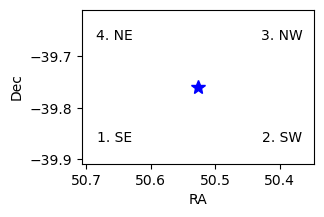

In [8]:
fig = plt.figure(figsize=(3, 2))
plt.plot(my_ra, my_dec, '*', ms=10, color='blue')
clabels = ['1. SE', '2. SW', '3. NW', '4. NE']
for corner, clabel in zip(corners, clabels):
    plt.text(corner[0], corner[1], clabel, ha='center', va='center')
plt.gca().invert_xaxis()
plt.xlim([ra1+0.05, ra2-0.05])
plt.ylim([dec1-0.05, dec2+0.05])
plt.xlabel('RA')
plt.ylabel('Dec')
plt.show()

> Figure 1: A small plot of RA vs. Dec to visualize the center (blue star) and the four corners (numbered and labeled) defined by the user for the large cutout. 

### 2.2. Identify the patch to use as anchor image

Use the butler to find the tract and patch within which
the central coordinates of the desired cutouts are most centered.

This will be the tract and patch referred to as the "anchor image"
when creating the big cutout.

In [9]:
my_point = geom.SpherePoint(my_ra * geom.degrees,
                            my_dec * geom.degrees)
skymap = butler.get('skyMap')
tract = skymap.findTract(my_point)
patch = tract.findPatch(my_point)
anchor_tract = tract.tract_id
anchor_patch = patch.getSequentialIndex()
print('anchor tract and patch: ', anchor_tract, anchor_patch)
del my_point, skymap, tract, patch

anchor tract and patch:  3442 13


### 2.3. Identify additional tracts and patches

In the future, it will be possible to write ADQL statements
that use the INTERSECTS functionality to identify all patches
(or images) that overlap with a defined polygon.

For now, use the TAP service to search the `coaddPatches` table
for images with central coordinates that indicate the patch
could *potentially* overlap with the defined extent of the 
desired cutout.

Increase the extent of the search by the patch size to make sure
no overlapping patch is missed.
This may well end up identifying a few patches that do not, in the end,
overlap with the extent of the desired cutout -- and that's ok.

In [10]:
sra1 = ra1 + 0.22
sra2 = ra2 - 0.22
sdec1 = dec1 - 0.22
sdec2 = dec2 + 0.22

scorners = np.asarray([[sra1, sdec1], [sra2, sdec1],
                       [sra2, sdec2], [sra1, sdec2]],
                      dtype='float')

Create the TAP query.

In [11]:
string_polygon = ""
for c, scorner in enumerate(scorners):
    s1 = str(np.round(scorner[0], 4))
    s2 = str(np.round(scorner[1], 4))
    string_polygon += s1 + ', ' + s2
    if c < 3:
        string_polygon += ', '
    del s1, s2

query = "SELECT lsst_patch,lsst_tract,s_dec,s_ra "\
        "FROM dp02_dc2_catalogs.CoaddPatches "\
        "WHERE CONTAINS(POINT('ICRS', s_ra, s_dec), "\
        "POLYGON('ICRS', "+string_polygon+"))=1"
print(query)

SELECT lsst_patch,lsst_tract,s_dec,s_ra FROM dp02_dc2_catalogs.CoaddPatches WHERE CONTAINS(POINT('ICRS', s_ra, s_dec), POLYGON('ICRS', 50.8766, -40.0789, 50.1764, -40.0789, 50.1764, -39.4389, 50.8766, -39.4389))=1


Run the TAP query.

In [12]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)

Job phase is COMPLETED


If the returned job phase was "error", uncomment the following to review the error.

In [13]:
# job.raise_if_error()

Retrieve the TAP results.

In [14]:
results = job.fetch_result().to_table()

Option to show the results.

In [15]:
# results

Hold the tract and patch values for images that 
will contribute, in addition to the anchor image,
to the final custom cutout in `add_tracts_and_patches`.

In [16]:
temp = []
for result in results:
    tract = result['lsst_tract']
    patch = result['lsst_patch']
    if (tract != anchor_tract) | (patch != anchor_patch):
        temp.append([tract, patch])
add_tracts_and_patches = np.asarray(temp, dtype='int')
del temp

print('add these to the anchor patch: ')
print(add_tracts_and_patches)

add these to the anchor patch: 
[[3442   19]
 [3441    7]
 [3441   14]
 [3442   20]
 [3442   12]]


## 3. Create the custom cutout

Define the filter of the desired custom cutout.

In [17]:
use_filter = 'r'

### 3.1. Define and display the anchor image

Define the `dataId` for the anchor image.

Use the butler to retrieve the anchor image and its World Coordinate System (WCS).

In [18]:
anchor_dataId = {'tract': anchor_tract, 'patch': anchor_patch,
                 'band': use_filter}
anchor_image = butler.get('deepCoadd_calexp', dataId=anchor_dataId)
anchor_wcs = butler.get('deepCoadd_calexp.wcs', dataId=anchor_dataId)
print(anchor_wcs)

FITS standard SkyWcs:
Sky Origin: (51.4285714286, -39.4214876033)
Pixel Origin: (13999, 13999)
Pixel Scale: 0.2 arcsec/pixel


Visually inspect the `anchor_image`. The below demonstration plots a circle centered at `my_ra` and `my_dec`, with diameter equal to the desired image box edge outlined above. The map indicates that the desired location is near the patch and tract edge and joining to other deepCoadds is required in order to display a contiguous image. 

(<matplotlib.patches.Circle at 0x7abaedf29990>,)

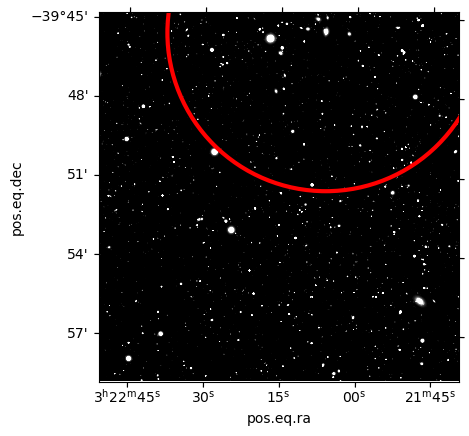

In [19]:
radius = box_side_deg/2. * u.deg
coord = SkyCoord(ra=my_ra*u.degree, dec=my_dec*u.degree, frame='icrs')

plt.subplot(projection=WCS(anchor_image.getWcs().getFitsMetadata()))
extent = (anchor_image.getBBox().beginX, anchor_image.getBBox().endX,
          anchor_image.getBBox().beginY, anchor_image.getBBox().endY)

plt.imshow(anchor_image.image.array, vmin=.1, vmax=1, extent=extent,
           origin='lower', cmap='gray')

anchor_bbox = anchor_image.getBBox()

aperture = SkyCircularAperture(coord, r=radius)
pix_aperture = aperture.to_pixel(WCS(anchor_image.getWcs().getFitsMetadata()))
pix_aperture.plot(color='r', lw=3)

> Figure 2: The anchor image patch, with a partial red circle indicating that the size of the desired large cutout is bigger than a single `deepCoadd` patch.

### 3.2. Define the other images to combine

Create the arrays of `dataId`s and images to be passed to `GetTemplateTask`.

In [20]:
all_dataIds = [anchor_dataId]
all_images = [anchor_image]
for i in range(len(add_tracts_and_patches)):
    temp_tract = add_tracts_and_patches[i][0]
    temp_patch = add_tracts_and_patches[i][1]
    temp_dataId = {'tract': temp_tract, 'patch': temp_patch,
                   'band': use_filter}
    temp_image = butler.get('deepCoadd_calexp', dataId=temp_dataId)

    all_images.append(temp_image)
    all_dataIds.append(temp_dataId)
    del temp_tract, temp_patch, temp_dataId, temp_image

Print the `dataId`s.

In [21]:
for dataId in all_dataIds:
    print(dataId)

{'tract': 3442, 'patch': 13, 'band': 'r'}
{'tract': 3442, 'patch': 19, 'band': 'r'}
{'tract': 3441, 'patch': 7, 'band': 'r'}
{'tract': 3441, 'patch': 14, 'band': 'r'}
{'tract': 3442, 'patch': 20, 'band': 'r'}
{'tract': 3442, 'patch': 12, 'band': 'r'}


### 3.3. Set up `getTemplateTask`

Define `getTemplateTask` which will enable the various images to be warped and resampled into one big cutout. 

No configuration changes are needed.

In [22]:
getTemplateTask = GetTemplateTask()

Build the WCS definition for the new cutout. There are two cases for how to proceed. 

#### 3.3.1. Within a single tract (limited use case)

If the desired cutout crosses patch boundaries but is within a single tract, then the pixel grids are exactly compatible, and no reprojection is needed. Pixels from adjacent patches can be exactly stitched together at the boundaries, without having to re-define a WCS and reproject the pixels onto it.  Pixels can be taken from the relevant patches and stitched into a single array.  If not reprojecting, be careful to preserve the CRPIX/CRVAL values of the inputs and not attempt to recenter the WCS on the cutout, because it's still on a tangent plane relative to the tract center.

This is _not_ the case that is demonstrated in this notebook, because the process for creating a big cutout that crosses tract boundaries is more general, and would work even if a tract boundary is not crossed.

#### 3.3.2. Crossing tract boundaries (general use case)

If the cutout crosses tract boundaries (which have independent projections and WCS), then it is necessary to reproject the input images to a new tangent plane centered at the target and with north up. This more general case is demonstrated below, and will work also for the simpler case of adjacent patches within one tract.

The cell below defines the new WCS for the joined images across both patch and tract boundaries.

The WCS consists of 4 components.

1) The RA and Dec of the center of the image defined as `crval`.

2) The center pixel (x, y) defined as `crpix`. <br>
In Section 1, the cutout area of interest is defined in `box_side_deg` as 0.2 degrees on a side (12 arcminutes).
The center is defined as `box_side_deg`, converted to arcsec and then divided in half.
Dividing that by the `deepCoadd` pixel scale of 0.2 arcsec/pixel results in the center pixel, in units of pixels.

3) The pixel scale, which is a 2x2 matrix defined as `cdMatrix`.<br>
Note that the pixel scale of all deepCoadds are always the same, so the new WCS can simply use the one from `anchor_image`.

5) The projection of the WCS `projection`, which is defined as `TAN` (referring to a new tangent projection centered at the `crval`).

In [23]:
crval = geom.SpherePoint(my_ra, my_dec, geom.degrees)

crpix = box_side_deg * 3600 / 2. / 0.2
crpix1 = crpix
crpix2 = crpix
crpix = geom.Point2D(crpix1, crpix2)

x = anchor_image.getWcs().getFitsMetadata()
cdMatrix = [x['CD1_1'], x['CD1_2']], [x['CD2_1'], x['CD2_2']]

projection = 'TAN'

Define the new WCS for the large cutout using the `makeSkyWcs` method based on the definition above.

In [24]:
newWCS = makeSkyWcs(crpix, crval, cdMatrix, projection)
print(newWCS)
print(anchor_image.getWcs())

FITS standard SkyWcs:
Sky Origin: (50.5265000000, -39.7589000000)
Pixel Origin: (1800, 1800)
Pixel Scale: 0.2 arcsec/pixel
FITS standard SkyWcs:
Sky Origin: (51.4285714286, -39.4214876033)
Pixel Origin: (13999, 13999)
Pixel Scale: 0.2 arcsec/pixel


Create a bounding box for the new image.

In [25]:
corner_SE_deg = geom.SpherePoint(corners[0][0], corners[0][1], geom.degrees)
corner_NW_deg = geom.SpherePoint(corners[2][0], corners[2][1], geom.degrees)
corner_SE_pix = newWCS.skyToPixel(corner_SE_deg)
corner_NW_pix = newWCS.skyToPixel(corner_NW_deg)

xmin = int(np.floor(corner_SE_pix[0]))
ymin = int(np.floor(corner_SE_pix[1]))
xmax = int(np.floor(corner_NW_pix[0]))
ymax = int(np.floor(corner_NW_pix[1]))

newimg_shape = Image(geom.Box2I(minimum=geom.Point2I(x=xmin, y=ymin),
                                maximum=geom.Point2I(x=xmax, y=ymax)),
                     dtype=np.float32)
newimage_bbox = newimg_shape.getBBox()

In [28]:
print(all_dataIds)

[{'tract': 3442, 'patch': 13, 'band': 'r'}, {'tract': 3442, 'patch': 19, 'band': 'r'}, {'tract': 3441, 'patch': 7, 'band': 'r'}, {'tract': 3441, 'patch': 14, 'band': 'r'}, {'tract': 3442, 'patch': 20, 'band': 'r'}, {'tract': 3442, 'patch': 12, 'band': 'r'}]


### 3.4. Create the big cutout image

Create the custom cutout as `newimage`.

>**Notice:** Some input patch images are skipped for not overlapping with the defined bounding box after all, as was expected (Section 2.3). The argument `physical_filter` is required to be passed, even though use of r-band was already specified above.

In [26]:
newimage = getTemplateTask.run(all_images, newimage_bbox,
                               newWCS, all_dataIds, physical_filter='r_sim_1.4')

TypeError: list indices must be integers or slices, not dict

getOverlappingExposures(inputs)

    Return lists of coadds and their corresponding dataIds that overlap the detector.

    The spatial index in the registry has generous padding and often supplies patches near, but not directly overlapping the detector. Filters inputs so that we don’t have to read in all input coadds.

    Parameters:

        inputsdict of task Inputs, containing:

                coaddExposureRefslist [lsst.daf.butler.DeferredDatasetHandle of lsst.afw.image.Exposure]
                    Data references to exposures that might overlap the detector.

                bboxlsst.geom.Box2I
                    Template Bounding box of the detector geometry onto which to resample the coaddExposures.

                skyMaplsst.skymap.SkyMap
                    Input definition of geometry/bbox and projection/wcs for template exposures.

                wcslsst.afw.geom.SkyWcs
                    Template WCS onto which to resample the coaddExposures.

    Returns:

        resultlsst.pipe.base.Struct
            A struct with attributes:
            coaddExposures
                Dict of Coadd exposures that overlap the detector, indexed on tract id (dict [int, list [lsst.afw.image.Exposure] ]).
            dataIds
                Dict of data IDs of the coadd exposures that overlap the detector, indexed on tract id (dict [int, list [`lsst.daf.butler.DataCoordinate] ]).

alternatively?:

expWcs = exposure.getWcs()

expBoxD = geom.Box2D(exposure.getBBox())

expBoxD.grow(self.config.templateBorderSize)

ctrSkyPos = expWcs.pixelToSky(expBoxD.getCenter())

tractInfo = skyMap.findTract(ctrSkyPos)

self.log.info("Using skyMap tract %s" % (tractInfo.getId(),))

skyCorners = [expWcs.pixelToSky(pixPos) for pixPos in expBoxD.getCorners()]

patchList = tractInfo.findPatchList(skyCorners)


In [27]:
# testing getOverlappingExposures
# more info at link
# https://pipelines.lsst.io/v/daily/py-api/lsst.ip.diffim.GetTemplateTask.html#lsst.ip.diffim.GetTemplateTask.getOverlappingExposures
#import lsst.pipe.drivers.utils # getDataRef
from lsst.daf.butler import DeferredDatasetHandle

getTemplateTask = GetTemplateTask()

# get a list of DeferredDatasetHandle datarefs

dI = all_dataIds[0]
dataset_refs = list(butler.registry.queryDatasets('deepCoadd', dataId=dI))#, **htm_kwargs))
dataset_refs = set(dataset_refs)

for dI in all_dataIds[1:]:
    dr = list(butler.registry.queryDatasets('deepCoadd', dataId=dI))
    dataset_refs = dataset_refs.union(set(dr))
    #ref.append(butler.registry.findDataset(datasetType="deepCoadd", dataId=all_dataIds[i]))
    #ref.append(DeferredDatasetHandle.get(all_dataIds[i]))
    #x = getDataRef(butler, dataId=dataId, datasetType="coadd")
    #datasetRefs = butler.registry.queryDatasets('deepCoadd', dataId=all_dataIds[i])
    #ref1.append(butler.registry.queryDatasets('deepCoadd', dataId=all_dataIds[i]))
    #print(datasetRefs)
    #ref1.append(DeferredDatasetHandle(butler, ref=datasetRefs, parameters=None))
    # = DeferredDatasetHandle(butler, ref=datasetRefs, parameters=None)
#for i, ref in enumerate(ref1):
#    print(ref.dataId)
#    print("band:", ref.dataId['band'])
#dict = {'coaddExposures':ref1, 'bbox':newimage_bbox, 'wcs':newWCS, 'all_dataIDs': all_dataIds}
#print(datasetRefs)
# notebook 04b has datasetref maybe
   

    #dataset_refs = dataset_refs.union(set(dr))


coadd_exposure_deferred_dataset_handles = [butler.getDeferred(dr) for dr in dataset_refs]
sky_map = butler.get("skyMap")
inputs = {"coaddExposures" : coadd_exposure_deferred_dataset_handles, 
          "bbox": newimage_bbox,
          "skyMap": sky_map,
          "wcs": newWCS,
          #"visitInfo": science.visitInfo,
         }

results = getTemplateTask.getOverlappingExposures(inputs)
coadd_exposures = results.coaddExposures
data_ids = results.dataIds

print(data_ids)



TypeError: Invalid type 'int64' of value 3442 for column literal.

## 4. Visualize the custom cutout

Extract metadata for the custom cutout.

In [ ]:
newimage_wcs = newimage.template.getWcs()
newimage_wcs_fmd = newimage.template.getWcs().getFitsMetadata()

newimage_extent = (newimage_bbox.beginX, newimage_bbox.endX,
                   newimage_bbox.beginY, newimage_bbox.endY)

### 4.1. Display with matplotlib

Compare the red circle in the larger cutout to that from the `anchor_image` in Section 3.1.
The full desired area is now accessible in one single contiguous cutout.

In [ ]:
fig = plt.figure(figsize=(8, 8))
plt.subplot(projection=WCS(newimage_wcs_fmd))
plt.imshow(newimage.template.image.array, vmin=0.01, vmax=0.5,
           extent=newimage_extent, origin='lower', cmap='gray')

aperture = SkyCircularAperture(coord, r=radius)
pix_aperture = aperture.to_pixel(WCS(newimage_wcs_fmd))
pix_aperture.plot(color='r', lw=3)

plt.show()

> Figure 3: The new image (large cutout) with a red circle marking the user-defined size.

#### 4.1.1. Draw input image boundaries

It can be useful to visualize and identify which region of the big joined image originated from which patch and tract.

Below is an example demonstrating how to identify the origin image for pixels in the big image, based on the input list of `dataIds` that were identified in Section 2. 

The code runs through all of the `dataIds` of the neighboring patchs and tracts, identifies the pixel values of the image corners in the new image, and plots the rectangular regions defining the original images (each as a different color).

In [ ]:
fig = plt.figure(figsize=(8, 8))
plt.subplot(projection=WCS(newimage_wcs_fmd))
plt.imshow(newimage.template.image.array, vmin=0.01, vmax=0.5,
           extent=newimage_extent, origin='lower', cmap='gray')

colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple']
i = 0
for dataId in all_dataIds:
    print(dataId, colors[i])
    dataId_image = butler.get('deepCoadd_calexp', dataId=dataId)
    dataId_wcs = butler.get('deepCoadd_calexp.wcs', dataId=dataId)
    dataId_bbox = dataId_image.getBBox()

    corners2 = [dataId_wcs.pixelToSky(dataId_bbox.beginX, dataId_bbox.beginY),
                dataId_wcs.pixelToSky(dataId_bbox.beginX, dataId_bbox.endY),
                dataId_wcs.pixelToSky(dataId_bbox.endX, dataId_bbox.endY),
                dataId_wcs.pixelToSky(dataId_bbox.endX, dataId_bbox.beginY)]

    corners_dataId_sky = [geom.SpherePoint(corners2[0].getRa().asDegrees(),
                                           corners2[0].getDec().asDegrees(),
                                           geom.degrees),
                          geom.SpherePoint(corners2[1].getRa().asDegrees(),
                                           corners2[1].getDec().asDegrees(),
                                           geom.degrees),
                          geom.SpherePoint(corners2[2].getRa().asDegrees(),
                                           corners2[2].getDec().asDegrees(),
                                           geom.degrees),
                          geom.SpherePoint(corners2[3].getRa().asDegrees(),
                                           corners2[3].getDec().asDegrees(),
                                           geom.degrees)]
    corners_dataId_pix = newWCS.skyToPixel(corners_dataId_sky)

    coord = [[corners_dataId_pix[0].getX(), corners_dataId_pix[0].getY()],
             [corners_dataId_pix[1].getX(), corners_dataId_pix[1].getY()],
             [corners_dataId_pix[2].getX(), corners_dataId_pix[2].getY()],
             [corners_dataId_pix[3].getX(), corners_dataId_pix[3].getY()]]

    # store the pixel values of the NE corner;
    # to be used to study PSF variation in Section 5
    if i == 0:
        NE_anchor_pix = np.floor(coord[2])

    coord.append(coord[0])  # repeat the first point to create a closed loop
    xs, ys = zip(*coord)  # create lists of x and y values

    plt.plot(xs, ys, color=colors[i])
    i = i+1

plt.show()

> Figure 4: The new image, with the bounding boxes of the six individual `deepCoadd` images which were identified as potential contributors to the big cutout shown in orange, purple, blue, red, green, and yellow.

### 4.2. Display with `afwDisplay`

As an option, display the big coadd with `afwDisplay`.

In [ ]:
fig = plt.figure(figsize=(8, 8))
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(newimage.template.image)
plt.show()

> Figure 5: The new image, displayed in greyscale with `afwDisplay`.

### 4.3. Display with Firefly

Firefly allows for interactive image display and manipulation.
See DP0.2 tutorial notebook 03b for a full demonstration of how to use Firefly within the Notebook Aspect.

Reset the `afwDisplay` backend to be Firefly and start the display.
A new tab will open, containing the Firefly interface.

In [ ]:
afwDisplay.setDefaultBackend('firefly')
afw_display = afwDisplay.Display(frame=1)

Display the image in Firely.

In [ ]:
afw_display.mtv(newimage.template)

The Firefly default is to visualize the mask plane with colors. 
Set the mask plane transparency to 100, fully transparent, to see only the pixel data.

In [ ]:
afw_display.setMaskTransparency(100)

### 4.4. Option to save as a FITS file

Save as a FITS file in the home directory.

> **Warning:** Images can take up a lot of disk space. Save and download with caution.

In [ ]:
username = os.environ.get('USER')
fnm = '/home/' + username + '/my_big_cutout.fits'
newimage.template.writeFits(fnm)
del username, fnm

## 5. Accessing the PSF metadata of the new cutout

Where the tracts overlap, the pixel values are averaged to generate the resulting template image.

The point-spread function (PSF) on the template (big cutout) is created by combining the `CoaddPsf` on each template image into a meta-CoaddPsf. Thus, it is possible to extract the PSF properties from any region of the new big cutout image, in the same way it is done for the `deepCoadd` images.

Below demonstrates the way to access the PSF meta data from the template image.  

More information on how to access PSF information can be found in DP0.2 tutorial notebooks 12a and 12b.

### 5.1. Compare the PSF size

First, check that the PSFs in the original image is the same as in that location of the template image. The first cell below will compare the PSFs at the location of the target, where the PSF is averaged across two patches. The shape of the PSF in the template is the same as the original to within 0.1-0.2%.


Compare the size (the width; the standard deviation or $\sigma$, `sigma`) of the PSF of the original (anchor) image
to that of the new (template) image for a fixed sky location: the user-defined center of the new image (`center`).

At this location, two patch images overlapped (as shown in Section 4.1.1.), so pixel data has been averaged, and some
small variation is to be expected.

Below it is shown that the PSF size in the anchor image is approximately the same in the new image, for the given location, 
within 0.2%.

In [ ]:
center = geom.SpherePoint(my_ra, my_dec, geom.degrees)

anchor_info = anchor_image.getInfo()
center_pix_anchor = anchor_wcs.skyToPixel(center)
newimage_info = newimage.template.getInfo()
center_pix_newimage = newWCS.skyToPixel(center)
point_tuple = (center_pix_anchor[0], center_pix_anchor[1])
point_image = geom.Point2D(point_tuple)
anchor_psf = anchor_image.getPsf()
psf_shape = anchor_psf.computeShape(point_image)
psf_sigma_old = psf_shape.getDeterminantRadius()
print("anchor center sigma=", psf_sigma_old)

newimage_psf = newimage.template.getPsf()
point_tuple = (center_pix_newimage[0], center_pix_newimage[1])
point_image = geom.Point2D(point_tuple)
psf_shape = newimage_psf.computeShape(point_image)
psf_sigma_new = psf_shape.getDeterminantRadius()
print("newimage center sigma=", psf_sigma_new)

percent_diff = np.abs(psf_sigma_old - psf_sigma_new)/psf_sigma_new * 100
print("percent difference is ", percent_diff, "%")

Next, check that the size of the PSF in the anchor image is the same as in the new image, for a location that is not averaged across multiple patches, but is warped to the new WCS.

The cell below compares the size of the PSFs at the location of the southeast corner (`corner_SE_deg` as defined in Section 2), where the PSF is derived only from the single original patch.

The size of the PSF in the new image is also the same as the anchor image to within $\sim$0.2%.

In [ ]:
center_pix = anchor_wcs.skyToPixel(corner_SE_deg)
point_tuple = (center_pix[0], center_pix[1])
point_image = geom.Point2D(point_tuple)
psf_shape = anchor_psf.computeShape(point_image)
psf_sigma_old = psf_shape.getDeterminantRadius()
print("anchor SE corner sigma=", psf_sigma_old)

center_pix = newWCS.skyToPixel(corner_SE_deg)
point_tuple = (center_pix[0], center_pix[1])
point_image = geom.Point2D(point_tuple)
psf_shape = newimage_psf.computeShape(point_image)
psf_sigma_new = psf_shape.getDeterminantRadius()
print("newimage SE corner sigma=", psf_sigma_new)

percent_diff = np.abs(psf_sigma_old - psf_sigma_new)/psf_sigma_new * 100
print("percent difference is ", percent_diff, "%")

### 5.2. Spatial variation in PSF differences
The following cell will more generally visualize the spatial variation of the percent difference of the PSF size using a heatmap, for just the part of anchor_image that overlaps the newimage.  To start, define the northwest and southwest corners of the overlapping region between `anchor_image` and `newImage` (`NE_anchor_pix` was stored in Section 4.1 for this purpose). Before display, the array has to be transposed using `.T` to match the orientation of the sky coordinates in the map above.

The heat map of percent difference in PSF sizes across the map indicate that any spatial variation is incredibly small, < 0.3 %. Note that the percent difference between the PSF of `anchor_image` and `newImage` increases at x-pixels > 1600, which marks the boundary where a second deepCoadd also contributes to the new image pixels and PSF properties (yellow box in Section 4.1).

In [ ]:
NW_x = NE_anchor_pix[0]
NW_y = NE_anchor_pix[1]

SE_x = 0
SE_y = 0

x_arr = np.arange(SE_x, NW_x, 300)
y_arr = np.arange(SE_y, NW_y, 300)

PSF_diff = np.zeros((len(x_arr), len(y_arr)))

for i in range(len(x_arr)):
    for j in range(len(y_arr)):
        point_new = geom.Point2D(x_arr[i], y_arr[j])
        sigma_new = newimage_psf.computeShape(point_new).getDeterminantRadius()
        coords4anchor = newWCS.pixelToSky(x_arr[i], y_arr[j])
        point_old = geom.Point2D(anchor_wcs.skyToPixel(coords4anchor))
        sigma_old = anchor_psf.computeShape(point_old).getDeterminantRadius()
        PSF_diff[i][j] = np.abs(sigma_old - sigma_new) / sigma_new * 100

plt.imshow(PSF_diff.T, cmap='rainbow',
           extent=[np.min(x_arr), np.max(x_arr),
                   np.min(y_arr), np.max(y_arr)])

plt.colorbar(label='Percent difference in PSF size')
plt.xlabel('new image pixels')
plt.ylabel('new image pixels')
plt.show()

> Figure 6: A heatmap showing the difference in PSF size between the anchor image and the new image, only for the area of the new image to which the anchor image contributed. The colorbar ranges from 0.12% (purple) to 0.26% (red). The difference in PSF size varies smoothly in the left half, where the new image is composed just from the anchor image. However, the difference in PSF size varies randomly in the right half, where the new image is composed of pixel data from both the anchor image and an adjacent image.